# Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

Using TensorFlow backend.


# Data Load

In [4]:
data = pd.read_csv("C:/Users/Galaxy/Desktop/csv/TSLA.csv")

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-08,22.887333,23.241333,20.973333,21.015333,21.015333,154719000
1,2018-02-09,21.328667,21.398666,19.650667,20.694668,20.694668,194005500
2,2018-02-12,21.075333,21.205334,20.416668,21.048668,21.048668,93417000
3,2018-02-13,21.001333,21.612667,20.834000,21.577333,21.577333,68403000
4,2018-02-14,21.389334,21.744667,21.234667,21.487333,21.487333,59260500


In [5]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2023-01-31,164.570007,174.300003,162.779999,173.220001,173.220001,196813500
1253,2023-02-01,173.889999,183.809998,169.929993,181.410004,181.410004,213806300
1254,2023-02-02,187.330002,196.750000,182.610001,188.270004,188.270004,217448300
1255,2023-02-03,183.949997,199.000000,183.690002,189.979996,189.979996,231684200
1256,2023-02-06,193.009995,198.169998,189.919998,194.759995,194.759995,186188100


# Compute Mid Price

## - 최고가와 최저가의 중간가격으로 예측하기 위한 설정

In [7]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows
## - 최근 50일 간의 데이터를 보고 내일을 예측하기 위한 window설정
## - 50개를 보고 1개를 예측하기 때문에, window 에 들어가는 총 데이터의 개수는 51개이다.

In [8]:
# window size
seq_len = 50

# 50개보고 1개 예측
sequence_length = seq_len + 1

result = []

for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data
## - 첫번째 Mid 값을 0으로 잡고 그 비율만큼 나머지 값들을 정해준다.
## - window를 싹 훑으면서 각 값을 첫번째 값으로 나눠준 다음에 1을 빼준다.
## - 그 후 training data와 test data를 나누어준 후 shuffle

In [9]:
normalized_data = []

for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

row = int(round(result.shape[0]*0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1085, 50, 1), (121, 50, 1))

# Build a Model

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (50,1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(1, activation='linear')) # 다음날 하루의 데이터를 예측
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Train

In [12]:
model.fit(x_train, y_train,
         validation_data = (x_test, y_test),
         batch_size=10,
         epochs=20)

Train on 1085 samples, validate on 121 samples
Epoch 1/20
1085/1085 [==============================] - 4s 4ms/step - loss: 0.0185 - val_loss: 0.0097
Epoch 2/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 3/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 4/20
1085/1085 [==============================] - 4s 3ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 5/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 6/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 7/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 8/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 9/20
1085/1085 [==============================] - 3s 3ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 10/20
1085/1085 [============

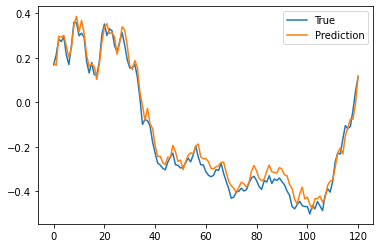

In [14]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# Save Model

In [13]:
model.save('lstmstock.h5')